检查台湾数据集

In [2]:
import os
import pandas as pd
import numpy as np

# 设定数据目录和文件
data_dir = '/data/scratch/jiayin/taiwan'
file_path = os.path.join(data_dir, 'Vehicular_All.csv')

# 读取数据
DataVeh = pd.read_csv(file_path)
print(DataVeh.head())

           Datetime   1  6  11  12  15  16  30  32  35  ...  43  44  45  54  \
0  2022/08/28 00:05   8  3  12   5   3   8  15  10  11  ...   2  16   3   1   
1  2022/08/28 00:10  18  3   4   3   9   7  20  20  13  ...   2  18   2   2   
2  2022/08/28 00:15  16  3   4   1   2  17  18   8  10  ...   5  12   0   3   
3  2022/08/28 00:20  11  5  11   5   3  11  12  10   2  ...   1   9   2   3   
4  2022/08/28 00:25  12  3   4   2   3   5  33  15   8  ...   3  13   4   0   

   56  57  59  62  63  202202  
0   5   5   3  12   1      12  
1   2   0   3  18   1      13  
2   6   0   2  10   0      21  
3   8   2   5  10   5      13  
4   3   4   6  17   3      10  

[5 rows x 22 columns]


(8928, 21)
Contains NaN: False
Contains Inf: False


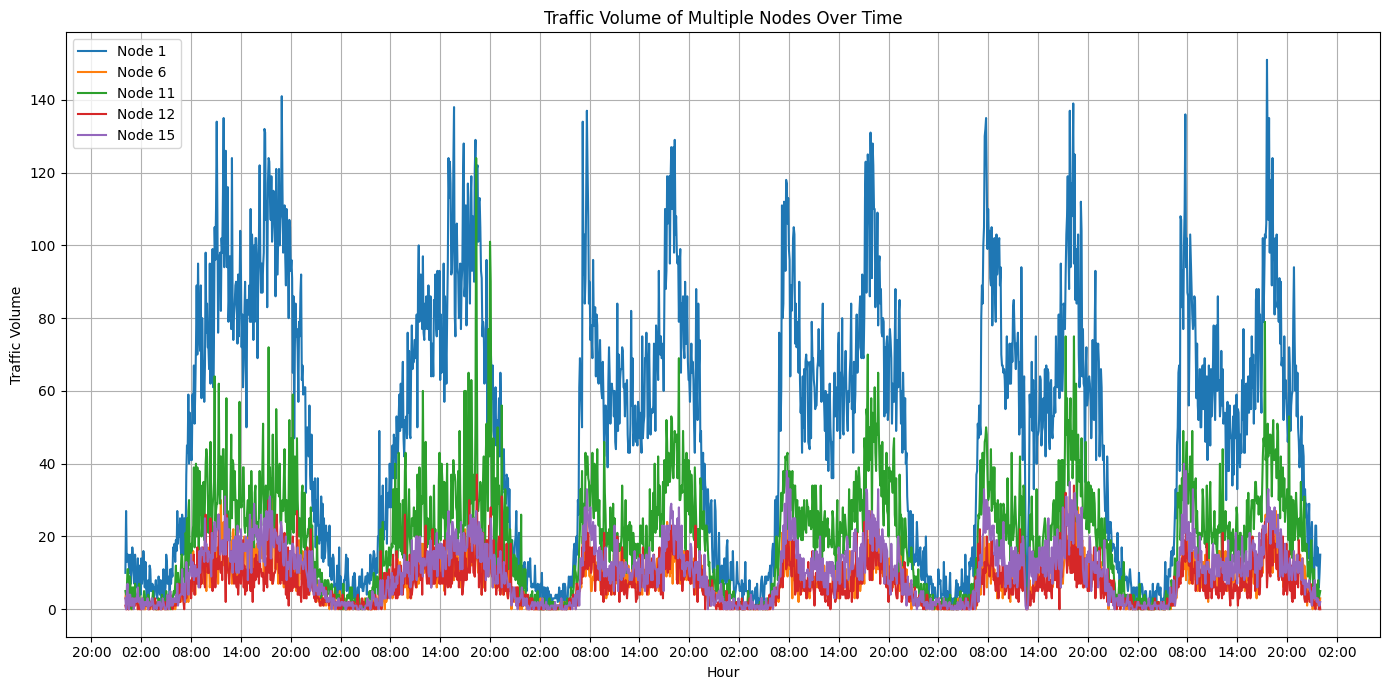

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 检查是否有NaN或Inf（跳过Datetime列）
DataVeh['Datetime'] = pd.to_datetime(DataVeh['Datetime'])
numeric_data = DataVeh.drop(columns=['Datetime']).apply(pd.to_numeric, errors='coerce')
print(numeric_data.shape)

has_nan = numeric_data.isnull().values.any()
has_inf = np.isinf(numeric_data.values).any()

print(f"Contains NaN: {has_nan}")
print(f"Contains Inf: {has_inf}")

# 指定要画的时间段，比如选取时间从index 200到500之间
start_time = 24*12*20  # 9.7
end_time = 24*12*26  # 9.13

# 指定要画的节点
nodes_to_plot = ['1', '6', '11', '12', '15']

# 画图
plt.figure(figsize=(14, 7))

for node in nodes_to_plot:
    plt.plot(
        DataVeh['Datetime'].iloc[start_time:end_time],  # x轴用实际时间
        numeric_data.iloc[start_time:end_time][node],   # y轴用流量
        label=f'Node {node}'
    )

# 画图后，拿到当前轴对象
ax = plt.gca()

# 判断时间跨度，动态设置Locator
time_span = (DataVeh['Datetime'].iloc[end_time-1] - DataVeh['Datetime'].iloc[start_time]).total_seconds() / 3600  # 单位小时

if time_span <= 6:
    locator = mdates.MinuteLocator(interval=10)  # 每10分钟一个tick
elif time_span <= 24:
    locator = mdates.HourLocator(interval=1)    # 每1小时一个tick
elif time_span <= 72:
    locator = mdates.HourLocator(interval=3)    # 每3小时一个tick
else:
    locator = mdates.HourLocator(interval=6)    # 每6小时一个tick或更稀疏

# 应用Locator和Formatter
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xticks(rotation=45)  # 最好旋转一下防止挤在一起
plt.xlabel('Hour')
plt.ylabel('Traffic Volume')
plt.title('Traffic Volume of Multiple Nodes Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=0)  # 不旋转也可以，因为只有小时很短
plt.tight_layout()
plt.show()


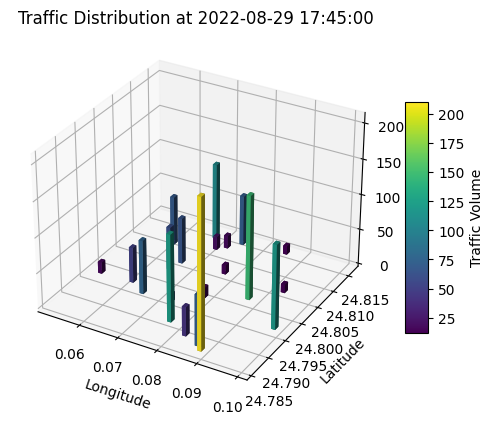

In [20]:
# 看空间立体图
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 数据路径
data_dir = '/data/scratch/jiayin/taiwan'

# 读取流量数据
DataVeh = pd.read_csv(os.path.join(data_dir, 'Vehicular_All.csv'))
DataVeh['Datetime'] = pd.to_datetime(DataVeh['Datetime'])
numeric_data = DataVeh.drop(columns=['Datetime']).apply(pd.to_numeric, errors='coerce')

# 读取节点坐标
coordinates = pd.read_csv(os.path.join(data_dir, 'coordinates.csv'))

# 选择一个时刻，比如第200行
time_idx = 500
flow_at_time = numeric_data.iloc[time_idx]

# 处理匹配
coordinates['road_segment'] = coordinates['road_segment'].astype(str)
flow_at_time = flow_at_time.rename_axis('road_segment').reset_index()

# 合并
data = pd.merge(coordinates, flow_at_time, on='road_segment')

# 提取绘图数据
x = data['Longitude']  # 经度
y = data['Latitude']   # 纬度
z = np.zeros_like(x)
dz = data[time_idx]    # 流量高度

# 画图
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# 颜色映射
norm = plt.Normalize(dz.min(), dz.max())
colors = plt.cm.viridis(norm(dz))

# 画柱子
dx = dy = 0.001  # 经纬度的宽度可以适当设置小一点
ax.bar3d(x, y, z, dx, dy, dz, color=colors, shade=True)

# 加colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
mappable.set_array(dz)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label='Traffic Volume')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Traffic Volume')
ax.set_title(f'Traffic Distribution at {DataVeh["Datetime"].iloc[time_idx]}')

plt.show()

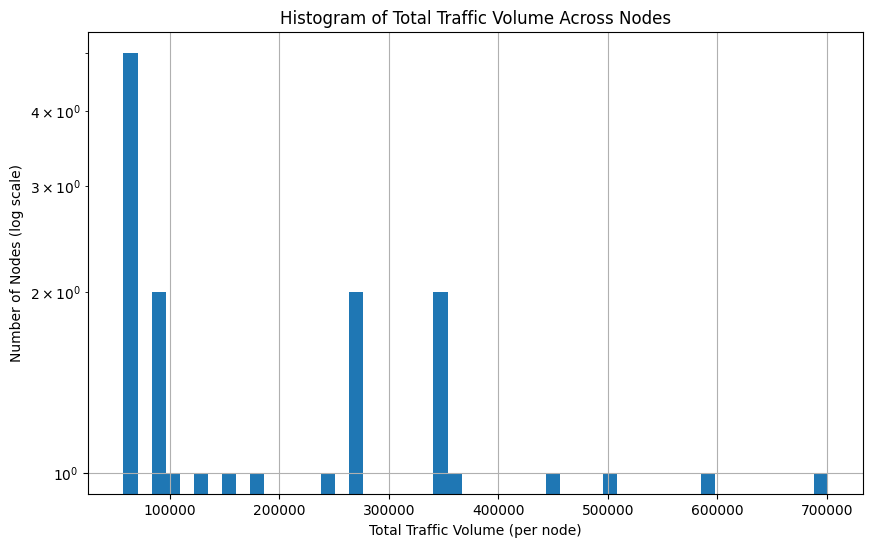

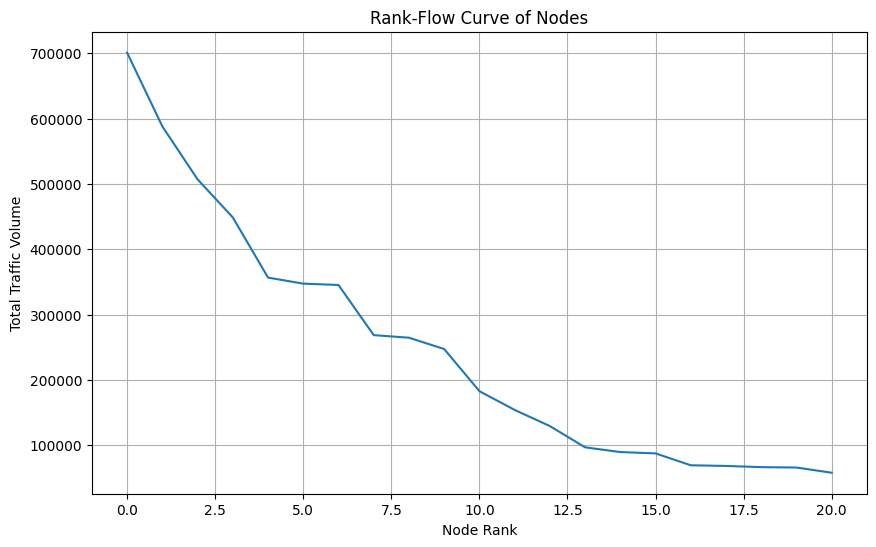

In [15]:
# 检查空间分布
# 可以看出不是幂律分布/长尾分布

import matplotlib.pyplot as plt
import numpy as np

# numeric_data 是之前处理后的数据（去掉了Datetime列）
total_flow_per_node = numeric_data.sum(axis=0)  # 每个节点累加

plt.figure(figsize=(10,6))
plt.hist(total_flow_per_node, bins=50, log=True)  # 注意：y轴log，可以放大尾部
plt.xlabel('Total Traffic Volume (per node)')
plt.ylabel('Number of Nodes (log scale)')
plt.title('Histogram of Total Traffic Volume Across Nodes')
plt.grid(True)
plt.show()
plt.close()

sorted_flow = total_flow_per_node.sort_values(ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,6))
plt.plot(sorted_flow.values)
plt.xlabel('Node Rank')
plt.ylabel('Total Traffic Volume')
plt.title('Rank-Flow Curve of Nodes')
plt.grid(True)
plt.show()
plt.close()

In [3]:
# 检查时间是否连续，间隔是否一致
DataVeh['Datetime'] = pd.to_datetime(DataVeh['Datetime'])
# 查看最早时间
earliest_time = DataVeh['Datetime'].min()

# 查看最晚时间
latest_time = DataVeh['Datetime'].max()

print("最早时间:", earliest_time)
print("最晚时间:", latest_time)
# 计算相邻时间差
time_diffs = DataVeh['Datetime'].diff().dropna()  # 第一行diff是NaT，丢掉

# 看看最常见的时间间隔
most_common_diff = time_diffs.mode()[0]  # 取出现频率最高的时间差
print(f"Most common time interval: {most_common_diff}")

# 检查是否所有时间间隔都相同
is_all_same_interval = (time_diffs == most_common_diff).all()

if is_all_same_interval:
    print("✅ 时间是连续且间隔一致的！")
else:
    print("❌ 时间不连续或时间间隔不一致！")

    # 找出异常的地方（时间跳变的地方）
    bad_indices = np.where(time_diffs != most_common_diff)[0]
    for idx in bad_indices:
        print(f"时间异常：第{idx}行 ({DataVeh['Datetime'].iloc[idx]}) 到 第{idx+1}行 ({DataVeh['Datetime'].iloc[idx+1]})，间隔为 {time_diffs.iloc[idx]}")

最早时间: 2022-08-28 00:05:00
最晚时间: 2022-09-28 00:00:00
Most common time interval: 0 days 00:05:00
✅ 时间是连续且间隔一致的！
